In [1]:
import os

import numpy as np
from openai import OpenAI

EMBEDDING_MODEL = 'text-embedding-3-small'

client = OpenAI(
    base_url=os.getenv('OPENAI_BASE_URL'),
    api_key=os.getenv('OPENAI_API_KEY'),
)

def get_embedding(text):
    text = text.replace('\n', ' ')
    resp = client.embeddings.create(input=[text], model=EMBEDDING_MODEL)
    return resp.data[0].embedding


def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    epsilon = 1e-10
    cosine_similarity = dot_product / (norm_a * norm_b + epsilon)
    return cosine_similarity


positive_review = get_embedding('好评')
negative_review = get_embedding('差评')

positive_example = get_embedding("买的银色版真的很好看，一天就到了，晚上就开始拿起来完系统很丝滑流畅，做工扎实，手感细腻，很精致哦苹果一如既往的好品质")
negative_example = get_embedding("随意降价，不予价保，服务态度差")


def get_score(sample_embedding):
    positive_similarity = cosine_similarity(sample_embedding, positive_review)
    negative_similarity = cosine_similarity(sample_embedding, negative_review)
    return positive_similarity - negative_similarity


positive_score = get_score(positive_example)
negative_score = get_score(negative_example)

print(f'好评例子的评分：{positive_score}')
print(f'差评例子的评分：{negative_score}')

好评例子的评分：0.1436832465680912
差评例子的评分：-0.09548049219312282


In [2]:
good_restaurant = get_embedding('这家餐馆太好吃了，一点都不糟糕')
bad_restaurant = get_embedding('这家餐馆太糟糕了，一点都不好吃')

good_restaurant_score = get_score(good_restaurant)
bad_restaurant_score = get_score(bad_restaurant)

print(f'好评餐馆的评分：{good_restaurant_score}')
print(f'差评餐馆的评分：{bad_restaurant_score}')

好评餐馆的评分：0.07214938301037083
差评餐馆的评分：-0.05212176686515646


In [3]:
import pandas as pd
from sklearn.metrics import classification_report

# https://github.com/openai/openai-cookbook/blob/main/examples/Get_embeddings_from_dataset.ipynb
datafile_path = os.path.join(os.getenv('SAMPLE_DATA_DIR'), 'fine_food_reviews_with_embeddings_1k.csv')
df = pd.read_csv(datafile_path)
df['embedding'] = df['embedding'].apply(eval).apply(np.array)
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].replace({
    1: 'negative',
    2: 'negative',
    4: 'positive',
    5: 'positive',
})

labels = [
    'An Amazon review with a negative sentiment.',
    'An Amazon review with a positive sentiment.',
]
label_embeddings = [get_embedding(label) for label in labels]


def label_score(review_embedding, label_embeddings):
    positive_similarity = cosine_similarity(review_embedding, label_embeddings[1])
    negative_similarity = cosine_similarity(review_embedding, label_embeddings[0])
    return positive_similarity - negative_similarity


probas = df['embedding'].apply(lambda x: label_score(x, label_embeddings))
preds = probas.apply(lambda x: 'positive' if x > 0 else 'negative')

report = classification_report(df['sentiment'], preds)
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.96      0.85       136
    positive       0.99      0.95      0.97       789

    accuracy                           0.95       925
   macro avg       0.88      0.96      0.91       925
weighted avg       0.96      0.95      0.95       925



Text(0.5, 1.0, '2-class Precision-Recall curve')

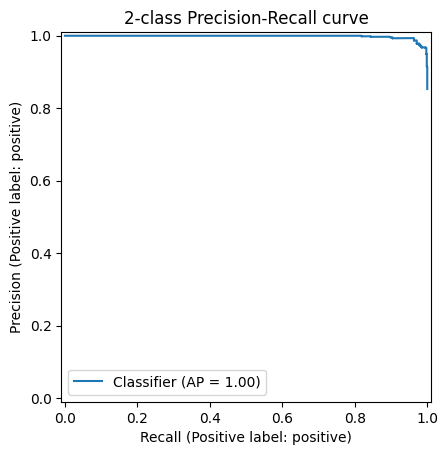

In [4]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(df['sentiment'], probas, pos_label='positive')
display.ax_.set_title('2-class Precision-Recall curve')